In [40]:
import numpy as np
import scipy.stats as st
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, Flatten, Dense, Lambda
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.losses import mean_squared_error, mean_absolute_error, categorical_crossentropy, binary_crossentropy
from keras.preprocessing.image import Iterator
import matplotlib.pyplot as plt
import cv2
import os
import json
import pickle
from datetime import datetime
%matplotlib inline

from keras.utils.np_utils import to_categorical

from keras.layers import Reshape, BatchNormalization

import tensorflow as tf
sess = tf.Session()
K.set_session(sess)

In [41]:
def get_noisy_scaled_dmap(dmap):
    m = np.max(dmap)
    noise = np.random.randn(*dmap.shape)
    
    if m != 0:
        mnoise = np.max(noise)
        s = (mnoise/m)    
    else:
        mnoise = np.mean(np.abs(noise))
        target = 0.3/dmap.size
        s = 1/(mnoise * target )
    
    noise /= s
    scaled = dmap * 5 + noise
    return np.clip(scaled, 0, 1e9)

In [42]:
def get_unet(n_channels=3, n_classes=1, batch_norm_down=False, batch_norm_up=False):
    # Fully convolutional, we don't specify the image size
    inputs = Input((224, 224, n_channels))
    
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(inputs)
    if batch_norm_down:
        conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv1)
    if batch_norm_down:
        conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(pool1)
    if batch_norm_down:
        conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv2)
    if batch_norm_down:
        conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(pool2)
    if batch_norm_down:
        conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv3)
    if batch_norm_down:
        conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(pool3)
    if batch_norm_down:
        conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv4)
    if batch_norm_down:
        conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(pool4)
    if batch_norm_down:
        conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='elu', padding='same')(conv5)
    if batch_norm_down:
        conv5 = BatchNormalization()(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    if batch_norm_up:
        up6 = BatchNormalization()(up6)
    conv6 = Conv2D(256, (3, 3), activation='elu', padding='same')(up6)
    if batch_norm_up:
        conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='elu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    if batch_norm_up:
        up7 = BatchNormalization()(up7)
    conv7 = Conv2D(128, (3, 3), activation='elu', padding='same')(up7)
    if batch_norm_up:
        conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='elu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    if batch_norm_up:
        up8 = BatchNormalization()(up8)
    conv8 = Conv2D(64, (3, 3), activation='elu', padding='same')(up8)
    if batch_norm_up:
        conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(64, (3, 3), activation='elu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    if batch_norm_up:
        up9 = BatchNormalization()(up9)
    conv9 = Conv2D(32, (3, 3), activation='elu', padding='same')(up9)
    if batch_norm_up:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(32, (3, 3), activation='elu', padding='same')(conv9)
    if batch_norm_up:
        conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(n_classes, (1, 1), activation='softmax', name="conv10")(conv9)
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [43]:
def get_block_loc(shape, x, y, target_size=(224, 224), n_blocks=(4,4), overlap=(448,448)):
    h, w = shape
    w_block = (w + (n_blocks[1] - 1) * overlap[1]) // n_blocks[1]
    h_block = (h + (n_blocks[0] - 1) * overlap[0]) // n_blocks[0]
    for by in range(n_blocks[0]):
        y_start = by * (h_block - overlap[0])
        y_end = y_start + h_block + 1
        for bx in range(n_blocks[1]):
            x_start = bx * (w_block - overlap[1])
            x_end = x_start + w_block + 1
            
            if x_start <= x < x_end and y_start <= y < y_end and\
            x_start <= x + target_size[1] - 1 < x_end and y_start <= y + target_size[0] - 1 < y_end:
                return bx + by * n_blocks[0], x - x_start, y - y_start
    raise Exception("Can't find block...??")

In [44]:
def normalize_image(im):
    n_channels = im.shape[2]
    im_normed = im.copy()
    
    for c in range(n_channels):
        min_channel = np.min(im[:,:,c])
        max_channel = np.max(im[:,:,c])
        a = 255.0/(max_channel - min_channel)
        b = -a * min_channel
        im_normed[:,:,c] = (a * im[:,:,c] + b).astype(np.uint8)
        
    return im_normed

In [45]:
class StreamStats(object):
    """ See https://www.johndcook.com/blog/standard_deviation/
    """
    def __init__(self):
        self.M = None
        self.S = None
        self.k = 0
        self.min = None
        self.max = None
        
    def update(self, x):
        self.k += 1
        if self.k == 1:
            self.M = x
            self.S = 0
            self.min = x
            self.max = x
        else:
            prevM = self.M
            prevS = self.S
            self.M = prevM + (x - prevM)/self.k
            self.S = prevS + (x - prevM) * (x - self.M)
            self.min = np.minimum(x, self.min)
            self.max = np.maximum(x, self.max)
            
    def mean(self):
        return self.M
        
    def variance(self):
        if self.k - 1 > 0:
            return self.S / (self.k - 1)
        else:
            return 0
    
    def std(self):
        return np.sqrt(self.variance())
    
    def minimum(self):
        return self.min
    
    def maximum(self):
        return self.max

In [46]:
def quantize(x, nbins, vmin, vmax):
    """ Transorm each value x[i] into an integer xq[i] in [0, nbins-1]
    """
    q = (vmax - vmin)/(nbins-1)
    k = np.floor((x - vmin)/q)
    return np.clip(k.astype(np.int32), 0, nbins-1)

In [47]:
def dequantize(x, nbins, vmin, vmax):
    q = (vmax - vmin)/(nbins-1)
    return (x * q) + vmin

In [48]:
def to_log_space(x):
    return np.log(x + 1e-9)

In [49]:
def from_log_space(x):
    return np.exp(x) - 1e-9

In [50]:
class PatchIterator(Iterator):
    """Iterator yielding training samples
    :param root_dir: Directory containing training images, density map and sampling map.
    :param image_ids: Set of image ids to use to sample patches.
    :param n_samples_per_image: Number of patches to sample on each image.
    :param target_size: Size of the patches sampled.
    :param batch_size: Number of patches sampled per batch
    :param shuffle: Boolean, whether to shuffle the data between epochs.
    :param seed: Random seed for data shuffling.
    :return batch_x, batch_x. 
        batch_x is a (batch_size, target_size[0], target_size[1], 3) array
        batch_x is a (batch_size, target_size[0], target_size[1], 1) array if output_counts is False
        otherwise, it is a (batch_size, 5) array.
    """

    def __init__(self, root_dir, image_ids, nbins=256,
                 x_scale=None, x_offset=None,
                 n_samples_per_image=160,
                 target_size=(224, 224),
                 batch_size=8, shuffle=True, seed=42):
        
        self.image_ids = image_ids
        self.x_scale = 1.0 if x_scale is None else x_scale
        self.x_offset = 0.0 if x_offset is None else x_offset
        self.nbins = nbins
        self.root_dir = root_dir
        self.n_samples_per_image = n_samples_per_image
        self.target_size = target_size
        self.n_indices = len(self.image_ids) * self.n_samples_per_image
        self.stats_mode = False
                 
        super(PatchIterator, self).__init__(self.n_indices, batch_size, shuffle, seed)
        
    def load_stats(self, version):
        self.x_scale = np.load(os.path.join(self.root_dir, "x_scale_" + version + ".npy"))
        self.x_offset = np.load(os.path.join(self.root_dir, "x_offset_" + version + ".npy"))
        self.y_log_min = np.load(os.path.join(self.root_dir, "y_log_min_" + version + ".npy"))
        self.y_log_max = np.load(os.path.join(self.root_dir, "y_log_max_" + version + ".npy"))
        
    def compute_stats(self, n_batches=100):
        version = str(datetime.timestamp(datetime.now()))
        self.stats_mode = True
        input_stats = StreamStats()
        log_output_stats = StreamStats()
        scaled_output_stats = StreamStats()
        
        for b in range(n_batches):
            bx, by = self.next()
            for b in range(bx.shape[0]):
                x = bx[b,...]
                x_normed = normalize_image(x)
                x_mean_bgr = np.mean(np.mean(x_normed/255, axis=0), axis=0)
                input_stats.update(x_mean_bgr)
            for b in range(by.shape[0]):
                y = by[b,...]
                ylog = to_log_space(y)
                for vy in ylog.ravel():
                    log_output_stats.update(vy)
                    
        self.x_scale = 1/(255 * input_stats.std())
        self.x_offset = -input_stats.mean()/input_stats.std()
        np.save(os.path.join(self.root_dir, "x_scale_" + version + ".npy"), self.x_scale)
        np.save(os.path.join(self.root_dir, "x_offset_" + version + ".npy"), self.x_offset)
        self.y_log_min = log_output_stats.minimum()
        self.y_log_max = log_output_stats.maximum()
        np.save(os.path.join(self.root_dir, "y_log_min_" + version + ".npy"), self.y_log_min)
        np.save(os.path.join(self.root_dir, "y_log_max_" + version + ".npy"), self.y_log_max)
        self.stats_mode = False
        return version

    def normalize_input(self, x):
        return x
        #return x * self.x_scale + self.x_offset
    
    def normalize_output(self, y):
        y_log = to_log_space(y)
        y_quant = quantize(y_log, self.nbins, self.y_log_min, self.y_log_max)
        return to_categorical(y_quant, num_classes=self.nbins).reshape(y.shape[:-1] + (-1,))
        
    def denormalize_output(self, y_quant):
        ylog = dequantize(y_quant, self.nbins, self.y_log_min, self.y_log_max)
        return from_log_space(ylog)
    
    def denormalize_input(self, x_normed):
        return(x_normed - self.x_offset)/self.x_scale
    
    def __sample__(self, shape, dots, image_id):
        pbackground = 0.2
        threshold_masked = 0.3 # if more than 30% of the patch is masked, reject it
        
        adots = []
        for _, ds in dots.items():
            for x, y in ds:
                if 0 <= x < shape[1] and 0 <= y < shape[0]:
                    adots.append((x, y))
                    
        bg_or_dots = np.random.choice(2, size=(1, ), p=[pbackground, 1-pbackground])
        
        while 1:
            if bg_or_dots[0] == 0 or len(adots) == 0:
                x, y = self.sample_bg(shape, image_id)
            else:
                x, y = self.sample_dot(shape, adots, image_id)

            try:
                bid, x, y = get_block_loc(shape, x, y)
            except:
                continue
            uid = "{iid}_{bid}".format(iid=image_id, bid=bid)
            img = cv2.imread(os.path.join(self.root_dir, "TrainBlock", uid + ".jpg"))
            img_patch = img[y:y+self.target_size[0], x:x+self.target_size[1],:]
            masked_pixels = np.count_nonzero(img_patch == 0)
            total_pixels = img_patch.shape[0] * img_patch.shape[1]
            if img_patch.shape[0] != self.target_size[0] or img_patch.shape[1] != self.target_size[1]:
                continue
            if masked_pixels/total_pixels < threshold_masked:
                dmap = np.load(os.path.join(self.root_dir, "TrainDensity", uid + ".npz"))['dmap']
                dmap = np.sum(dmap, axis=-1, keepdims=True)
                dmap_patch = dmap[y:y+self.target_size[0], x:x+self.target_size[1], :]
                dmap_noisy = get_noisy_scaled_dmap(dmap_patch)
                return dmap_noisy, dmap_patch
        
    def sample_bg(self, shape, image_id):
        x = np.random.randint(0, shape[1] - self.target_size[1], size=(1,))[0]
        y = np.random.randint(0, shape[0] - self.target_size[0], size=(1,))[0]
        
        return x, y
    
    def sample_dot(self, shape, adots, image_id):
        half_size = 36
        
        randi = np.random.choice(len(adots), size=(1,))[0]
        rand_dot = adots[randi]
        
        min_x = max(0, rand_dot[0] - self.target_size[1] + half_size)
        max_x = min(shape[1] - self.target_size[1], rand_dot[0] + self.target_size[1] - half_size)
        
        min_y = max(0, rand_dot[1] - self.target_size[0] + half_size)
        max_y = min(shape[0] - self.target_size[0], rand_dot[1] + self.target_size[0] - half_size)
        
        if min_x >= max_x:
            max_x, min_x = min_x, max_x
        if min_y >= max_y:
            max_y, min_y = min_y, max_y 
           
        x = np.random.randint(min_x, max_x, size=(1,))[0]
        y = np.random.randint(min_y, max_y, size=(1,))[0]
        
        return x, y
        
    def next(self):
        """For python 2.x.
        # Returns
            The next batch.
        """
        # Keeps under lock only the mechanism which advances
        # the indexing of each batch.
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
                 
        batch_x = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 1), dtype=K.floatx())
        batch_y = np.zeros((current_batch_size, self.target_size[0], self.target_size[1], 1), dtype=K.floatx())
        
        # For each index, we load the data and sample randomly n_successive_samples patches
        for i, j in enumerate(index_array):
            index = j // self.n_samples_per_image
            image_id = self.image_ids[index]
            with open(os.path.join(self.root_dir, "TrainDots", str(image_id) + ".pkl"), "rb") as pfile:
                dots = pickle.load(pfile)
            with open(os.path.join(self.root_dir, "TrainShape", str(image_id) + ".pkl"), "rb") as pfile:
                shape = pickle.load(pfile)
                
            x, y = self.__sample__(shape, dots, image_id)
            batch_x[i,:,:,:] = x
            batch_y[i,:,:,:] = y    
        
        if self.stats_mode:
            return self.normalize_input(batch_x), batch_y
        else:
            return self.normalize_input(batch_x), self.normalize_output(batch_y)
    

In [14]:
with open("../data/sealion/train.json", "r") as jfile:
    train_ids = json.load(jfile)
train_ids = [int(s[:-4]) for s in train_ids]

In [15]:
with open("../data/sealion/dots_ok.json", "r") as jfile:
    dots_ok = json.load(jfile)
dots_ok = [int(s[:-4]) for s in dots_ok]

In [16]:
train_ids = list(set(train_ids).intersection(set(dots_ok)))

In [17]:
with open("../data/sealion/val.json", "r") as jfile:
    val_ids = json.load(jfile)
val_ids = [int(s[:-4]) for s in val_ids]
val_ids = list(set(val_ids).intersection(set(dots_ok)))

In [18]:
nbins=128

In [19]:
trainPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", train_ids, nbins=nbins, batch_size=4)
trainPatchesGenerator.load_stats('1494147889.725409')

In [20]:
valPatchesGenerator = PatchIterator("/home/lowik/sealion/data/sealion/", val_ids, nbins=nbins, batch_size=4)
valPatchesGenerator.load_stats('1494147889.725409')

In [36]:
weights_per_class = np.ones((nbins, ))
weights_per_class[0] = 0.9

In [37]:
def w_categorical_crossentropy(y_true, y_pred):
    y_true_r = K.reshape(y_true, (4, 224*224, 128))
    y_pred_r = K.reshape(y_pred, (4, 224*224, 128))
    weights = K.max(y_true_r * weights_per_class, axis=-1)
    loss_per_pixel = K.categorical_crossentropy(y_pred_r, y_true_r)
    return loss_per_pixel * weights

In [54]:
unet = get_unet(1, n_classes=nbins, batch_norm_down=False, batch_norm_up=False)
sgd = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=True)
rmsprop = RMSprop(lr=0.0001)
unet.compile(optimizer=rmsprop, loss=w_categorical_crossentropy)

In [55]:
h = unet.fit_generator(trainPatchesGenerator, 200, epochs=10, verbose=1, callbacks=None, validation_data=valPatchesGenerator, validation_steps=50, class_weight=None, max_q_size=1, workers=1, pickle_safe=False, initial_epoch=0)

Epoch 1/10
111/200 [===============>..............] - ETA: 1018s - loss: 2.8155

KeyboardInterrupt: 

In [21]:
for batch_x, batch_y in valPatchesGenerator:
    break

In [22]:
batch_y.shape

(4, 224, 224, 128)

In [23]:
batch_x.shape

(4, 224, 224, 1)

In [30]:
batch_ypred = unet.predict(batch_x)

In [31]:
batch_ypred.shape

(4, 224, 224, 128)

In [32]:
batch_x.shape

(4, 224, 224, 1)

In [33]:
g = np.argmax(batch_ypred, axis=-1)

In [34]:
g

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   2,   0, ...,   0,   0,   0],
        ..., 
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[102,  55,  44, ...,  30, 121,  88],
        [ 62,  44,  94, ...,  27,  23,  94],
        [ 57,  55,  24, ...,  84, 121,  30],
        ..., 
        [ 32,   9,  56, ...,  12, 121,  90],
        [  7,  77,  80, ...,  19,  84,  60],
        [ 28, 101,  22, ...,  61,   0, 121]],

       [[ 13,  13,   4, ...,  27,  27, 113],
        [ 13,  13,  27, ...,  94,  94,  12],
        [110,  13,  80, ...,  18,  94,  18],
        ..., 
        [ 14,  60,  36, ..., 121,  48, 121],
        [ 80,  54,  59, ...,  39,  44,  62],
        [101,  22,  39, ...,  42, 121,  90]],

       [[ 14,  54,  30, ...,  18,  10,   3],
        [ 24,  13,  86, ..., 121,   3,   0],
        [ 24,  23, 101, ...,  14,  34,  27],
       

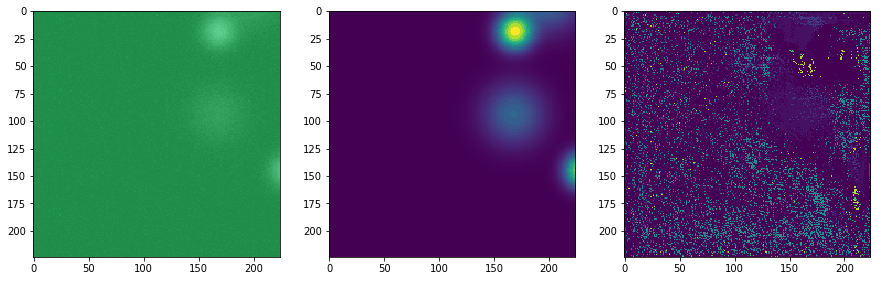

In [35]:
i = 2
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(valPatchesGenerator.denormalize_input(batch_x[i,:,:, :]))
plt.subplot(132)
plt.imshow(valPatchesGenerator.denormalize_output(np.argmax(batch_y, axis=-1)[i,:,:]))
plt.subplot(133)
plt.imshow(valPatchesGenerator.denormalize_output(np.argmax(batch_ypred, axis=-1)[i,:,:]))

In [ ]:
np.sum(valPatchesGenerator.denormalize_output(batch_y[i,:,:, 0]))

In [ ]:
np.sum(valPatchesGenerator.denormalize_output(batch_ypred[i,:,:, 0]))